In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections
import random

#generate random id
import uuid

#ICC in python
import pingouin as pg

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score
from xgboost import plot_importance
#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import is_WG_open, ConfMat, list_of_zones, res_intodico, all_subsets
import config_origins as config

C:\Users\camil\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Download Input Data

In [3]:
#define parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
dico_garden_opening_hour = config.dico_garden_opening_hour
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
#path_extracted_data_cleaning = r'D:\vm_exchange\PhD_Data\LogsCleaning'
#create a director if not existing
if not os.path.exists(path_extracted_data_cleaning):
    os.makedirs(path_extracted_data_cleaning)
    
path__ = os.path.join(path_extracted_data_cleaning,'1secTS')
#create a director if not existing
if not os.path.exists(path__):
    os.makedirs(path__)

In [4]:
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'InputCleaning.csv'), parse_dates=['Timestamp', 'date'], 
                 dayfirst=True, sep=';')
df = shuffle(df)
df = df.rename(columns={c:c.replace('_','') for c in df.columns})
df['HenID'] = df['HenID'].map(lambda x: 'hen_'+str(int(x)))
print(df.shape)
df.head(3)

(3193, 36)


,Timestamp,TagID,HenID,Zone,PenID,VideoAnalyse,system,date,type,signalstrength,...,previousZone==NextZone,nextduration,BatchID,zone2match,zone3match,zone4match,ObservedZone,zone3matchexist,next2zone==Zone,previous2zone==Zone
2812,2020-10-25 09:04:09,139,hen_65,3_Zone,10.0,1,10 - 12,2020-10-25,students,7.0,...,True,30.0,NaN,3_Zone,4_Zone,NoOtherZone,3_Zone,True,False,False
689,2020-10-15 12:06:12,60,hen_88,5_Zone,5.0,1,3 - 5,2020-10-15,students,9.0,...,True,64.0,NaN,3_Zone,2_Zone,4_Zone,5_Zone,True,False,True
3171,2020-10-16 10:13:19,144,hen_165,3_Zone,11.0,1,10 - 12,2020-10-16,students,8.0,...,True,22.0,ID16,3_Zone,miniZone3,NoOtherZone,3_Zone,True,True,True


In [5]:
df['PenID'].value_counts()

10.0    654
8.0     604
3.0     517
5.0     516
9.0     372
12.0    221
4.0     217
11.0     92
Name: PenID, dtype: int64

In [6]:
df['VideoAnalyse'].value_counts()

1    2576
0     617
Name: VideoAnalyse, dtype: int64

# Data preprocessing

In [7]:
#available features (zone4match is totally point less it ~never exist)
licat = ['TagID', 'Zone', 'PenID', 'VideoAnalyse', 'system', 'date',
         'zone2match', 'zone3match','zone3matchexist',
         'next1zone','next2zone', 'next3zone', 'next4zone', 'next5zone',
         'previous1zone', 'previous2zone', 'previous3zone', 'previous4zone','previous5zone']
licont = ['signalstrength', 'signalstzone2', 'signalstrzone3', 'signalstrzone4', 'duration','previousduration','nextduration',
         'next2zone==Zone','previous2zone==Zone','previousZone==NextZone']

#select some features
li_cont_select = ['signalstrength', 'signalstzone2','duration','nextduration','previousduration',
                 'next2zone==Zone','previous2zone==Zone','zone3matchexist'] 
li_cat_select = ['Zone','zone2match','previous1zone','next1zone'] #ADD WHEN WE HAVE DORIS DATA: PenID
#zone3match_exist: important for WG cleaning

In [8]:
df[li_cont_select].head(3)

,signalstrength,signalstzone2,duration,nextduration,previousduration,next2zone==Zone,previous2zone==Zone,zone3matchexist
2812,7.0,5.0,23.0,30.0,11.0,False,False,True
689,9.0,8.0,18.0,64.0,10.0,False,True,True
3171,8.0,7.0,130.0,22.0,53.0,True,True,True


In [9]:
#scaling numercial data: necessary due to duration high values
sc = StandardScaler()
df[li_cont_select] = sc.fit_transform(df[li_cont_select])
df[li_cont_select].head(3)

,signalstrength,signalstzone2,duration,nextduration,previousduration,next2zone==Zone,previous2zone==Zone,zone3matchexist
2812,-0.870740,-0.563642,-0.046173,-0.049852,-0.202119,-1.428619,-1.432683,0.675767
689,-0.404369,0.210426,-0.046802,-0.045607,-0.202897,-1.428619,0.697991,0.675767
3171,-0.637554,-0.047596,-0.032714,-0.050851,-0.169453,0.699977,0.697991,0.675767


# Split into training-validation and testing (holdout dataset)

In [10]:
#necessary in order to later sum categories within the features importances
for x in li_cat_select+['ObservedZone']:
    df[x] = df[x].map(lambda x: str(x).replace('_',''))
df[li_cont_select+li_cat_select].head(3)

,signalstrength,signalstzone2,duration,nextduration,previousduration,next2zone==Zone,previous2zone==Zone,zone3matchexist,Zone,zone2match,previous1zone,next1zone
2812,-0.870740,-0.563642,-0.046173,-0.049852,-0.202119,-1.428619,-1.432683,0.675767,3Zone,3Zone,3Zone,3Zone
689,-0.404369,0.210426,-0.046802,-0.045607,-0.202897,-1.428619,0.697991,0.675767,5Zone,3Zone,3Zone,3Zone
3171,-0.637554,-0.047596,-0.032714,-0.050851,-0.169453,0.699977,0.697991,0.675767,3Zone,3Zone,3Zone,3Zone


In [11]:
#show rows with at least one nan
df[df.isna().any(axis=1)]

,Timestamp,TagID,HenID,Zone,PenID,VideoAnalyse,system,date,type,signalstrength,...,previousZone==NextZone,nextduration,BatchID,zone2match,zone3match,zone4match,ObservedZone,zone3matchexist,next2zone==Zone,previous2zone==Zone
2812,2020-10-25 09:04:09,139,hen_65,3Zone,10.0,1,10 - 12,2020-10-25,students,-0.870740,...,True,-0.049852,NaN,3Zone,4_Zone,NoOtherZone,3Zone,0.675767,-1.428619,-1.432683
689,2020-10-15 12:06:12,60,hen_88,5Zone,5.0,1,3 - 5,2020-10-15,students,-0.404369,...,True,-0.045607,NaN,3Zone,2_Zone,4_Zone,5Zone,0.675767,-1.428619,0.697991
203,2020-10-17 02:21:40,3,hen_104,5Zone,3.0,1,3 - 5,2020-10-17,students,-0.404369,...,True,-0.046606,NaN,2Zone,NoOtherZone,NoOtherZone,5Zone,-1.479801,0.699977,0.697991
1012,2020-10-16 15:01:34,117,hen_177,1Zone,10.0,1,10 - 12,2020-10-16,students,-0.870740,...,True,-0.048229,NaN,NoOtherZone,NoOtherZone,NoOtherZone,1Zone,-1.479801,-1.428619,-1.432683
2910,2020-10-24 14:41:45,44,hen_79,1Zone,4.0,1,3 - 5,2020-10-24,students,-1.803482,...,False,0.172365,NaN,NoOtherZone,NoOtherZone,NoOtherZone,1Zone,-1.479801,-1.428619,-1.432683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,2020-10-25 11:38:47,49,hen_122,3Zone,12.0,1,10 - 12,2020-10-25,students,1.694302,...,True,-0.041363,NaN,3Zone,4_Zone,NoOtherZone,3Zone,0.675767,-1.428619,0.697991
820,2020-10-18 14:59:08,115,hen_143,5Zone,10.0,1,10 - 12,2020-10-18,students,0.761560,...,False,-0.040489,NaN,3Zone,2_Zone,4_Zone,5Zone,0.675767,-1.428619,-1.432683
2239,2020-10-16 15:59:33,8,hen_20,3Zone,3.0,1,3 - 5,2020-10-16,students,-0.404369,...,True,-0.048604,NaN,miniZone3,2_Zone,NoOtherZone,3Zone,0.675767,0.699977,0.697991
544,2020-10-18 12:57:10,76,hen_62,3Zone,8.0,1,8 - 9,2020-10-18,students,0.994745,...,False,-0.051100,NaN,2Zone,5_Zone,NoOtherZone,3Zone,0.675767,0.699977,-1.432683


In [12]:
#exception
print(df.shape)
df = df[~((df['nextduration'].isnull())&(df['algotype']=='cleaning'))]
print(df.shape)

(3193, 36)
(3193, 36)


In [13]:
df_testing = df[df['algotype']=='verification'].copy()
df_cleaning = df[df['algotype']=='cleaning'].copy()

In [14]:
df_cleaning['VideoAnalyse'].value_counts()

1    2307
0     604
Name: VideoAnalyse, dtype: int64

In [15]:
print(df_testing.shape, df_cleaning.shape)

(282, 36) (2911, 36)


# Split into training and validation (for parameter tuning)

In [16]:
#transform categorical data into dumies
df_cl_d = pd.get_dummies(df_cleaning.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)
df_te_d = pd.get_dummies(df_testing.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)

if len(df_te_d.columns)!=len(df_cl_d.columns):
    print('the test set does not have the same amount of features than the cleaning set, certainly due to low amount of data,\
    Please remove some varibles that has missing values in the testing set')
    sys.exit()
    
#split into train, test and vlaidation as its simpler like this. But for algo from sklearn, we should add val+train together,
#while for the Catboost we will not add them up
#train
X_train = df_cl_d.values
y_train = df_cleaning[['VideoAnalyse']].values
print(X_train.shape, y_train.shape)

#test
X_test = df_te_d.values
y_test = df_testing[['VideoAnalyse']].values
y_test = np.ravel(y_test) #from (x,1) to (x,)
print(X_test.shape, y_test.shape)

#var name
var_name = df_cl_d.columns

#split training into validation
val_size = 0.2   
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=0)
y_train = np.ravel(y_train) #from (x,1) to (x,)
y_val = np.ravel(y_val) #from (x,1) to (x,)
#add back for sklearn models
X_trainval = np.concatenate((X_train,X_val), axis=0)
y_trainval = np.concatenate((y_train,y_val), axis=0)

#small control: show rows with at least one nan
if df_cl_d[df_cl_d.isna().any(axis=1)].shape[0]!=0:
    print('ERROR: you have nan in your cleaning set')
    sys.exit()
if df_te_d[df_te_d.isna().any(axis=1)].shape[0]!=0:
    print('ERROR: you have nan in your testing set')
    sys.exit()

(2911, 26) (2911, 1)
(282, 26) (282,)


# Model

In [17]:
li_dico = []

### 1 - Random forest & GradientBoostingMachine

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:32<00:00,  1.79s/it]


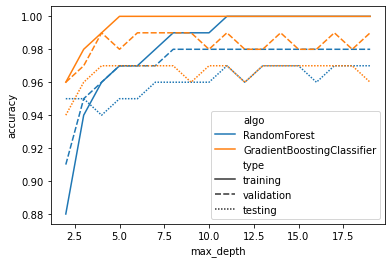

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.13it/s]


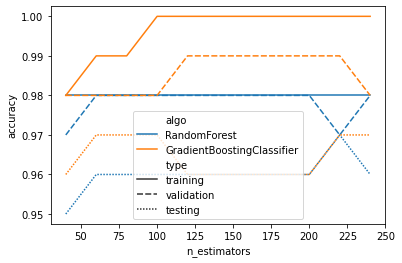

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.69it/s]


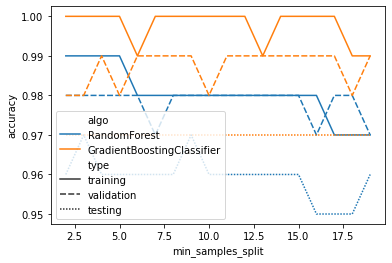

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.74it/s]


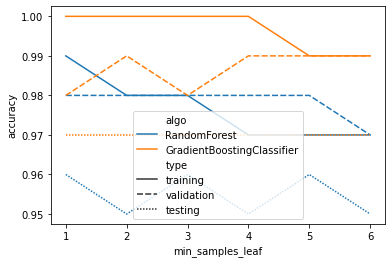

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.11it/s]


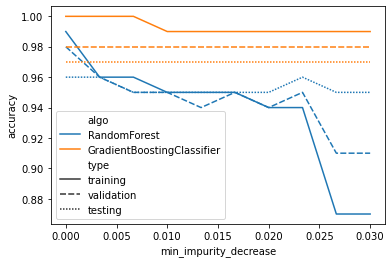

In [69]:
#FIRST: SEE WHICH RANGE FOR EACH PARAMETER AVOIDING OVERFITTING
li_plt = []
dico_hyperparam_values = {'max_depth': range(2,20),
                          'n_estimators': range(40,300,20),
                          'min_samples_split':range(2,20),
                          'min_samples_leaf':range(1,7),
                          'min_impurity_decrease':[x for x in np.linspace(start = 0, stop = 0.03, num = 10)]}

#lets fix maxdepth first and then keep rest default except max_features
for hp,li in dico_hyperparam_values.items():
    for v in tqdm.tqdm(li):
        if hp=='max_depth':
            dico_mod = {'RandomForest':RandomForestClassifier(max_features='sqrt', random_state=0,
                                                             max_depth=v),
                        'GradientBoostingClassifier': GradientBoostingClassifier(max_features='sqrt', random_state=0,
                                                                                 max_depth=v)}
        if hp=='n_estimators':
            dico_mod = {'RandomForest':RandomForestClassifier(max_features='sqrt', random_state=0,
                                                              max_depth = 9,                                                                                 min_samples_split=10,
                                                              n_estimators=v),
                        'GradientBoostingClassifier': GradientBoostingClassifier(max_features='sqrt', random_state=0,
                                                                                 max_depth = 5, 
                                                                                 n_estimators=v)}
        if hp=='min_samples_split':
            dico_mod = {'RandomForest':RandomForestClassifier(max_features='sqrt', random_state=0,
                                                              max_depth = 9, 
                                                              min_samples_split=v),
                        'GradientBoostingClassifier': GradientBoostingClassifier(max_features='sqrt', random_state=0,
                                                                                 max_depth = 5,
                                                                                 min_samples_split=v)}
        if hp=='min_samples_leaf':
            dico_mod = {'RandomForest':RandomForestClassifier(max_features='sqrt', random_state=0,
                                                              max_depth = 9, 
                                                              min_samples_leaf=v),
                        'GradientBoostingClassifier': GradientBoostingClassifier(max_features='sqrt', random_state=0,
                                                                                 max_depth = 5, 
                                                                                 min_samples_leaf=v)}
        if hp=='min_impurity_decrease':
            dico_mod = {'RandomForest':RandomForestClassifier(max_features='sqrt', random_state=0,
                                                              max_depth = 9, 
                                                              min_impurity_decrease=v),
                        'GradientBoostingClassifier': GradientBoostingClassifier(max_features='sqrt', random_state=0,
                                                                                 max_depth = 5, 
                                                                                 min_impurity_decrease=v)}
        for name,mod in dico_mod.items():
            mod.fit(X_train, y_train)
            li_plt.append({'algo':name, hp:v, 'type':'training', 'accuracy':round(mod.score(X_train, y_train),2)})
            li_plt.append({'algo':name, hp:v, 'type':'validation', 'accuracy':round(mod.score(X_val, y_val),2)})
            li_plt.append({'algo':name, hp:v, 'type':'testing', 'accuracy':round(mod.score(X_test, y_test),2)})
            #save it
            #predictor.score(X,Y) internally calculates Y'=predictor.predict(X) and then compares Y' against Y to give an accuracy
            #measure. This applies not only to logistic regression but to any other model.
            li_dico.append({'algo':name, 'model_param_used':mod,
                            'accuracy_training':round(mod.score(X_train, y_train),2),
                            'accuracy_validation':round(mod.score(X_val, y_val),2),
                            'accuracy_testing':round(mod.score(X_test, y_test),2)})
    sns.lineplot(data=pd.DataFrame(li_plt), x=hp, y="accuracy", hue="algo", style="type");
    plt.savefig(os.path.join(path_extracted_data_cleaning,id_run+'_ClassifierParamTuning_'+hp+'.png'), bbox_inches='tight')
    plt.show()

#OLD FIRST: have an idea on what are the good parameters
P = {'bootstrap': [True],
      'max_depth': [int(x) for x in np.linspace(start = 2, stop = 6, num = 4)],
      'max_features': ['sqrt'], #nbr of features to consider when looking for the best split
      'min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 15, num = 4)],#min samples at a leaf node
      'min_samples_split':[int(x) for x in np.linspace(start = 2, stop = 10, num = 4)], #min sample that can be split alone
      'n_estimators':[int(x) for x in np.linspace(start = 50, stop = 1500, num = 4)],#nbr of trees in the forest default=100
      'criterion':['gini', 'entropy'],
      'min_impurity_decrease':[x for x in np.linspace(start = 0.0001, stop = 0.05, num = 4)]}
mod = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = P, n_iter = 200, cv = 3, verbose=2, 
                               random_state=0, n_jobs = -1)
mod.fit(X_train, y_train)
mod = mod.best_estimator_
display(mod)

### 1- Random Forest

In [20]:
#THEN: refine the parameters
P = {'max_features': ['sqrt'], #nbr of features to consider when looking for the best split
      'criterion':['gini', 'entropy'],
      'max_depth': [5,6],
      'min_samples_leaf': [2,3],#min samples at a leaf node
      'min_samples_split':[2,3,4], #min nbr of samples required to split a node, we may want this to be bigger for RF (more complex trees)
      'n_estimators':[800,900,1000],#nbr of trees in the forest default=100
      'min_impurity_decrease':[x for x in np.linspace(start = 0.0001, stop = 0.01, num = 2)],
      'bootstrap': [True],
      'class_weight': [{0:x1/x0, 1:1}]}
#define the model with all these options and fit it (as many combinationa s asked for)
mod = GridSearchCV(estimator = RandomForestClassifier(), param_grid = P, cv = 3, n_jobs = -1, verbose = 2) 
mod.fit(X_train, y_train)
#define the best model and fit it 
mod_final = mod.best_estimator_
mod_final.fit(X_train, y_train)
display(mod_final)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  3.0min finished
C:\Users\camil\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(criterion='entropy', max_depth=6,
                       min_impurity_decrease=0.0001, min_samples_leaf=2,
                       min_samples_split=0.15, n_estimators=900)

In [21]:
li_dico.append({'algo':'randomforest', 'model_param_used':mod_final, 
                'accuracy_training':round(mod_final.score(X_train, y_train),3),
                'accuracy_validation':round(mod_final.score(X_val, y_val),3),
                'accuracy_testing':round(mod_final.score(X_test, y_test),3)})
pd.DataFrame(li_dico)

,algo,model_param_used,accuracy_training,accuracy_validation,accuracy_testing
0,randomforest,"(DecisionTreeClassifier(criterion='entropy', m...",0.931,0.953,0.947


### 2 - GradientBoostingClassifier

#FIRST: have an idea on what are the good parameters
#Create the parameter grid based on the results of random search 
#n_estimaro: The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number
#usually results in better performance.
P = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)],
     'learning_rate':[x for x in np.linspace(start = 0.05, stop = 0.2, num = 10)],
     'loss':['deviance', 'exponential'],
     'min_samples_split':[int(x) for x in np.linspace(start = 2, stop = 10, num = 4)],,
     'min_samples_leaf':[int(x) for x in np.linspace(start = 1, stop = 15, num = 4)],
     'max_depth': [int(x) for x in np.linspace(start = 2, stop = 6, num = 4)],
     'min_impurity_decrease':[x for x in np.linspace(start = 0.0001, stop = 0.05, num = 4)],
     'max_features': ['sqrt']
    }
mod = RandomizedSearchCV(estimator = GradientBoostingClassifier(), param_distributions = P, n_iter = 200, cv = 3, verbose=2, 
                        random_state=0, n_jobs = -1)
mod.fit(X_train, y_train)
mod = mod.best_estimator_
display(mod)

In [19]:
#THEN: refine the parameters
P = {'max_features': ['sqrt'],
     'n_estimators': [180,200], #the more trees you add, the higher the risk of overfitting!! default:100
     'min_samples_split':[2,3,4],
     'min_samples_leaf':[4,5,6],
     'max_depth': [4,5,6], #if to big: risk of overfitting default=3, should be smaller than RF, trees here should be simpler
     'min_impurity_decrease':[0.0001],
     'learning_rate':[0.1,0.15],
     'loss':['deviance'], #deviance is greatant boosting, otherwise its adap which is least robust to noise TODO: other as well???
     'criterion':['friedman_mse','mse','mae'],
     'validation_fraction':[val_size], #to have early stopping avoiding overfitting keep same as for catboost
     'n_iter_no_change':range(3,10),#to have early stopping avoiding overfitting. If set to a number, it will set aside validation_fraction size of the training data as validation and terminate training when validation score is not improving in all of the previous n_iter_no_change numbers of iterations.
     'tol':[x for x in np.linspace(start = 10**-8, stop = 10**-2, num = 10)]#to have early stopping avoiding overfitting. default 1e-4 
     
    }
mod = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = P, cv = 3, n_jobs = -1, verbose = 2) 
mod.fit(X_trainval, y_trainval)
mod_final = mod.best_estimator_
mod_final.fit(X_trainval, y_trainval)
display(mod_final)

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3570 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4522 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5373 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 5832 out of 5832 | elapsed:  6.6min finished


GradientBoostingClassifier(max_depth=6, max_features='sqrt',
                           min_impurity_decrease=0.0001, min_samples_leaf=4,
                           min_samples_split=4, n_estimators=200,
                           n_iter_no_change=5, tol=1e-10,
                           validation_fraction=0.2)

In [21]:
li_dico.append({'algo':'GradientBoostingClassifier', 'model_param_used':mod_final, 
                'accuracy_training':round(mod_final.score(X_train, y_train),3),
                'accuracy_validation':round(mod_final.score(X_val, y_val),3),
                'accuracy_testing':round(mod_final.score(X_test, y_test),3)})
pd.DataFrame(li_dico)

,algo,model_param_used,accuracy_training,accuracy_validation,accuracy_testing
0,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,0.992,0.991,0.965
1,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,0.992,0.991,0.965


### 3 - Catboost

In [22]:
#https://towardsdatascience.com/catboost-demystified-8b0b538bfa31
#ordered stat: https://medium.com/data-from-the-trenches/how-do-gradient-boosting-algorithms-handle-categorical-variables-e56ace858ba2

In [21]:
#THEN: refine the parameters
#Info: https://catboost.ai/docs/concepts/python-reference_parameters-list.html
x1 = df_cleaning[df_cleaning['VideoAnalyse']==1].shape[0]
x0 = df_cleaning[df_cleaning['VideoAnalyse']==0].shape[0]
print(x1/x0)
P = {'n_estimators': range(600,2000,300), #the more trees you add, the higher the risk of overfitting!! default:1000!
     'l2_leaf_reg': range(1,5),#default is 3
     'loss_function': ['Logloss'], #for binary classification
     'max_depth': range(4,15,1), #if to big: risk of overfitting default=6
     'min_data_in_leaf': range(1,3), #The minimum number of training samples in a leaf (equivalent to min_samples_leaf). default 1
     'class_weights': [{0:1, 1:1}, {0:x1/x0, 1:1}], #multiply the weight of object of class 0 by 1 and the object of class 1 by 0.2
     'od_pval': [x for x in np.linspace(start = 10**-10, stop = 10**-2, num = 4)], #The larger the value, the earlier overfitting is detected., defualt=0, but it is recommanded to be tested for these range
     'od_wait':[10]#, #instead of the default 20 :Ignore the overfitting detector when the threshold is reached and continue learning for the specified number of iterations after the iteration with the optimal metric value.
     #'use_best_model':[True]
    }
mod = GridSearchCV(estimator = CatBoostClassifier(), param_grid = P, cv = 3, n_jobs = -1, verbose = 2) 
eval_dataset = Pool(X_val,y_val)
mod.fit(X_train, y_train) #, eval_set=eval_dataset, verbose=False)
mod_final = mod.best_estimator_
mod_final.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)
display(mod_final.get_params())

3.8195364238410594
Fitting 3 folds for each of 3520 candidates, totalling 10560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.6s
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\camil\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-7206985b2817>", line 18, in <module>
    mod.fit(X_train, y_train) #, eval_set=eval_dataset, verbose=False)
  File "C:\Users\camil\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\camil\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 736, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\camil\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1188, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\camil\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 715, in evaluate_candidates
    cv.split(X, y, groups)))
  File "C:\Users\camil\Anaconda3\lib\site-packages\joblib\parallel.py", line 

TypeError: object of type 'NoneType' has no len()

In [25]:
#THEN: refine the parameters
#Info: https://catboost.ai/docs/concepts/python-reference_parameters-list.html
x1 = df_cleaning[df_cleaning['VideoAnalyse']==1].shape[0]
x0 = df_cleaning[df_cleaning['VideoAnalyse']==0].shape[0]
print(x1/x0)
P = {'n_estimators': range(600,2000,100), #the more trees you add, the higher the risk of overfitting!! default:1000!
     'l2_leaf_reg': range(1,10),#default is 3
     'loss_function': ['Logloss'], #for binary classification
     'max_depth': range(4,15,1), #if to big: risk of overfitting default=6
     'min_data_in_leaf': range(1,7), #The minimum number of training samples in a leaf (equivalent to min_samples_leaf). default 1
     'class_weights': [{'0':1, '1':1}, {'0':x1/x0, '1':1}], #multiply the weight of object of class 0 by 1 and the object of class 1 by 0.2
     'od_pval': [x for x in np.linspace(start = 10**-10, stop = 10**-2, num = 10)], #The larger the value, the earlier overfitting is detected., defualt=0, but it is recommanded to be tested for these range
     'od_wait':[10], #instead of the default 20 :Ignore the overfitting detector when the threshold is reached and continue learning for the specified number of iterations after the iteration with the optimal metric value.
     'use_best_model':[True]
    }
mod = GridSearchCV(estimator = CatBoostClassifier(), param_grid = P, cv = 3, n_jobs = -1, verbose = 2) 
eval_dataset = Pool(X_val,y_val)
mod.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)
mod_final = mod.best_estimator_
mod_final.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)
display(mod_final.get_params())

3.8195364238410594
Fitting 3 folds for each of 166320 candidates, totalling 498960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PicklingError: Could not pickle the task to send it to the workers.

In [60]:
#save
li_dico.append({'algo':'Catboost', 'model_param_used':mod_final.get_all_params(), 
                'accuracy_training':round(mod_final.score(X_train, y_train),3),
                'accuracy_validation':round(mod_final.score(X_val, y_val),3),
                'accuracy_testing':round(mod_final.score(X_test, y_test),3)})
pd.DataFrame(li_dico)

,algo,model_param_used,accuracy_training,accuracy_validation,accuracy_testing
0,Catboost,<catboost.core.CatBoostClassifier object at 0x...,0.902,0.891,0.858
1,Catboost,<catboost.core.CatBoostClassifier object at 0x...,0.966,0.956,0.940
2,Catboost,<catboost.core.CatBoostClassifier object at 0x...,0.979,0.968,0.933
3,Catboost,<catboost.core.CatBoostClassifier object at 0x...,0.986,0.967,0.940
4,GradientBoostingClassifier,<catboost.core.CatBoostClassifier object at 0x...,0.986,0.967,0.940
5,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,1.000,0.974,0.968
6,Catboost,<catboost.core.CatBoostClassifier object at 0x...,0.981,0.966,0.940
7,Catboost,<catboost.core.CatBoostClassifier object at 0x...,0.998,0.967,0.943
8,Catboost,<catboost.core.CatBoostClassifier object at 0x...,1.000,0.971,0.954
9,Catboost,<catboost.core.CatBoostClassifier object at 0x...,1.000,0.973,0.950


In [ ]:
'CrossEntropy', 'Logloss'


In [ ]:

Lq ?
MAPE
Poisson
PairLogit
PairLogitPairwise
QueryRMSE
QuerySoftMax
Tweedie
YetiRank
YetiRankPairwise
StochasticFilter
StochasticRank

### * - K-neighrest neigbors

An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.
WE CHOOSED this algorithm as we want a simple rule based algorithm, that wont give us any bad surprise.
try weight with: 'distance' or 'uniform', i.e.weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
he k-nearest neighbour classifier can be viewed as assigning the k nearest neighbours a weight {\displaystyle 1/k}1/k and all others 0 weight. 
Since this algorithm relies on distance for classification, normalizing the training data can improve its accuracy dramatically

#FIRST: have an idea on what are the good parameters
#Create the parameter grid based on the results of random search 
P = {'n_neighbors': [int(x) for x in np.linspace(start = 3, stop = 20, num = 10)],
     'weights': ['uniform', 'distance'],
     'leaf_size':[int(x) for x in np.linspace(start = 15, stop = 80, num = 10)],
     'p':[1,2,3,4]}
mod = RandomizedSearchCV(estimator = KNeighborsClassifier(), param_distributions = P, n_iter = 200, cv = 3, verbose=2, 
                               random_state=0, n_jobs = -1)
mod.fit(X_train, y_train)
mod = mod.best_estimator_
display(mod)

#THEN: refine the parameters
P = {'n_neighbors': [14,15,16,17,18],
     'weights': ['uniform', 'distance'],
     'leaf_size':[35,40,45,50],
     'p':[1,2]}
mod = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = P, cv = 3, n_jobs = -1, verbose = 2) 
mod.fit(X_train, y_train)
mod_final = mod.best_estimator_
mod_final.fit(X_train, y_train)
display(mod_final)

li_dico.append({'algo':'K-neighrest neigbors', 'model_param_used':mod_final, 
                'accuracy_training':round(mod_final.score(X_train, y_train),3),
                'accuracy_validation':round(mod_final.score(X_val, y_val),3),
                'accuracy_testing':round(mod_final.score(X_test, y_test),3)})
pd.DataFrame(li_dico)

### * - XGBClassifier

In [70]:
#parameters documentation: https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
#TO CHECK IN MORE DEDTAILED IF BEST MODEL; OTHERWISE DONT USE IT 

#FIRST: have an idea on what are the good parameters
#min_split_loss: minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more 
#conservative the algorithm will be.
P = {'n_estimators': [int(x) for x in np.linspace(start = 2, stop = 200, num = 10)],
     'learning_rate':[x for x in np.linspace(start = 0.05, stop = 0.7, num = 10)],
     'max_depth':[int(x) for x in np.linspace(start = 3, stop = 10, num = 10)], #not to big otherwise overfitting, default: 6
     'booster': ['gbtree', 'gblinear','dart'],
     'feature_selector' :['shuffle','greedy','cycle'],
     'top_k':[0]+[int(x) for x in np.linspace(start = 10, stop = len(var_name), num = 10)],
     'min_split_loss':[x for x in np.linspace(start = 0.0001, stop = 0.2, num = 10)]}
mod = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = P, n_iter = 200, cv = 3, verbose=2, 
                        random_state=0, n_jobs = -1)
mod.fit(X_train, y_train)
mod = mod.best_estimator_
display(mod)

#THEN: refine the parameters
P = {'n_estimators': [15,20,25,30],
    'learning_rate':[0.3,0.4,0.5,0.6],
    'max_depth':[6,8,10],
    'booster': ['gbtree', 'gblinear','dart'],
    'feature_selector':['cycle'],
    'top_k':[18],
    'min_split_loss':[0.03,0.04,0.05]}
mod = GridSearchCV(estimator = XGBClassifier(), param_grid = P, cv = 3, n_jobs = -1, verbose = 2) 
mod.fit(X_train, y_train)
mod_final = mod.best_estimator_
mod_final.fit(X_train, y_train)
display(mod_final)

li_dico.append({'algo':'XGBClassifier', 'model_param_used':mod_final, 
                'accuracy_training':round(mod_final.score(X_train, y_train),3),
                'accuracy_validation':round(mod_final.score(X_val, y_val),3),
                'accuracy_testing':round(mod_final.score(X_test, y_test),3)})
pd.DataFrame(li_dico)

### BEST MODEL

In [62]:
model = GradientBoostingClassifier(learning_rate=0.15, max_depth=4, max_features=9,
                           min_impurity_decrease=0.0001, min_samples_leaf=5,
                           min_samples_split=0.1, n_estimators=700)
eval_dataset = Pool(X_val,y_val)
model.fit(X_train, y_train, eval_set=eval_dataset)
#model.fit(X_train, y_train)
li_dico.append({'algo':'FINAL_GradientBoostingClassifier', 'model_param_used':model, 
                'accuracy_training':round(model.score(X_train, y_train),3),
                'accuracy_validation':round(model.score(X_val, y_val),3),
                'accuracy_testing':round(model.score(X_test, y_test),3)})

pd.DataFrame(li_dico)

TypeError: fit() got an unexpected keyword argument 'eval_set'

In [32]:
#TODO: INTERPRET EACH OF THE CHOOSEN FINAL PARAMETERS VALUES

# Feature importance

attention to good for categorical variable and RF
REad about this when knowing the final algo!!!

#plot feature importance: Fscore!
plot_importance(model)
plt.show()

#old
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
feature_importance = model.feature_importances_
#make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
plt.figure(figsize=(3, 7))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, var_name[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

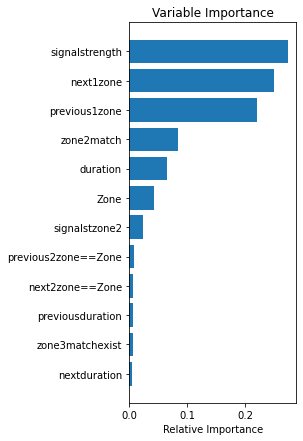

In [33]:
feature_importance = model.feature_importances_
# make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
dico_f_imp = {var_name[i]:feature_importance[i] for i in range(0,len(var_name))}
#display(dico_f_imp)
dico_fg_imp = {x.split('_')[0]:sum([dico_f_imp[i] for i in dico_f_imp.keys() if i.split('_')[0]==x.split('_')[0]]) for x in dico_f_imp.keys()}
#display(dico_fg_imp)
#sort the dictionary by the importance values
dico_fg_imp_sorted = {k: v for k, v in sorted(dico_fg_imp.items(), key=lambda item: item[1])}
plt.figure(figsize=(3, 7))
pos = [i+0.5 for i in range(0,len(dico_fg_imp))]
plt.barh(pos, dico_fg_imp_sorted.values(), align='center')
plt.yticks(pos, dico_fg_imp_sorted.keys())
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig(os.path.join(path_extracted_data_cleaning,'FeaturesImportance.png'), bbox_inches='tight')
plt.show()

# Relevance on TESTING DATA

In [34]:
#TO ADD NEW BATCHES WHEN WE HAVE NEW ONES
dico_BatchID_endhour = {'ID1':16,
                        'ID2':16,
                        'ID3':16,
                        'ID5':13,
                        'ID8':12,
                        'ID9':12,
                        'ID10':16,
                        'ID11':12,
                        'ID12':16,
                        'ID13':13,
                        'ID14':16,
                        'ID17':12}

In [35]:
##########################################################################################################
################################################ predict #################################################
##########################################################################################################
#transform categorical data into dumies
df_te_d = pd.get_dummies(df_testing.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)
X_test = df_te_d.values
#y_test = df_testing[['VideoAnalyse']].values
predictions = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
df_testing['model_prediction'] = predictions
df_testing['model_prediction_proba0'] = [round(x[0],2) for x in prediction_proba]
df_testing['model_prediction_proba1'] = [round(x[1],2) for x in prediction_proba]
df_testing.groupby(['Zone','model_prediction'])['date'].count().reset_index()
#add the zone that would be selected with this algorithm output: if==0, then the true zone is the one before
df_testing['model_prediction_init'] = df_testing['model_prediction'].astype(str)
df_testing['VideoAnalyse'] = df_testing['VideoAnalyse'].astype(str)
df_testing['model_ObservedZone'] = df_testing.apply(lambda x: x['Zone'] if x['model_prediction_init']=='1' else x['previous1zone'],
                                                    axis=1)
df_testing['tracking_prediction'] = 1
#save
df_testing.to_csv(os.path.join(path_extracted_data_cleaning, id_run+'_TestingMethods.csv'), 
                      index=False, sep=';')
#display(df_testing.head(3))

In [36]:
#visualise how correct is the prediction compared to the certainty of the algo
df_testing['is_correct4plot'] = df_testing.apply(lambda x: x['VideoAnalyse']==x['model_prediction_init'], axis=1)
display(df_testing[['VideoAnalyse', 'model_prediction_init', 'model_prediction_proba0', 
                    'model_prediction_proba1','is_correct4plot']].head(3))
df_testing.groupby(['is_correct4plot','VideoAnalyse'])[['model_prediction_init', 
                                    'model_prediction_proba0', 'model_prediction_proba1']].agg(lambda x: np.median(list(x))).reset_index()

,VideoAnalyse,model_prediction_init,model_prediction_proba0,model_prediction_proba1,is_correct4plot
3326,0,0,0.98,0.02,True
3502,1,1,0.00,1.00,True
3411,1,1,0.00,1.00,True


,is_correct4plot,VideoAnalyse,model_prediction_proba0,model_prediction_proba1
0,False,0,0.215,0.785
1,False,1,0.955,0.045
2,True,0,0.990,0.010
3,True,1,0.000,1.000


In [37]:
#add rule: if max proba is <0.8 then keep correct record. Can be used to comapre the method!!
df_testing['model_prediction'] = df_testing.apply(lambda x: '1' if max(x['model_prediction_proba0'],
                                                            x['model_prediction_proba1'])<0.8 else x['model_prediction_init'], axis=1)
df_testing['is_correct4plot_'] = df_testing.apply(lambda x: x['VideoAnalyse']==x['model_prediction'], axis=1)
display(df_testing['is_correct4plot'].value_counts(), df_testing['is_correct4plot_'].value_counts())

True     270
False     12
Name: is_correct4plot, dtype: int64

True     273
False      9
Name: is_correct4plot_, dtype: int64

In [38]:
df_testing['VideoAnalyse'].value_counts()

1    269
0     13
Name: VideoAnalyse, dtype: int64

In [39]:
##########################################################################################################
################################# select pairs' combinations of batches ##################################
##########################################################################################################

#number of combination's pair to run for each size
nbr_comb = 4
#minimum nbr of batches to have in a run
min_nbr_batch = 6 #5 is the minimum for transition reliability

#compute all possible batch combinations of any size
li_batch = df_testing['BatchID'].unique()
li_batch_combination = list(all_subsets(li_batch))

#list of distinct pairs of batch combinations of different size
li_selected_combination_pairs = []
#to have distinct pairs, we cant do more than half of what we have
for nbr_batch in tqdm.tqdm(range(min_nbr_batch, int(len(li_batch)/2))):
    li_sel = []
    li = [x for x in li_batch_combination if len(x)==nbr_batch]
    while len(li_sel)!=nbr_comb:
        li = shuffle(li)
        x1 = li[0]
        for l in li:
            if 2*len(l)==len(set(l+x1)):
                li_sel.append([x1,l])
                #ensure we dont use the sme twice
                li.remove(l) ; li.remove(x1)
                break
    li_selected_combination_pairs.extend(li_sel)
#do the one with all batches for final outputs
li_selected_combination_pairs.append([tuple(li_batch),tuple(li_batch)])
li_selected_combination_pairs[0:3]

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 41.64it/s]


[[('ID15', 'ID14', 'ID16', 'ID5', 'ID8', 'ID6'),
  ('ID4', 'ID11', 'ID2', 'ID3', 'ID1', 'ID13')],
 [('ID4', 'ID15', 'ID11', 'ID14', 'ID9', 'ID5'),
  ('ID2', 'ID3', 'ID16', 'ID7', 'ID13', 'ID6')],
 [('ID11', 'ID14', 'ID16', 'ID5', 'ID17', 'ID8'),
  ('ID4', 'ID2', 'ID12', 'ID10', 'ID7', 'ID13')]]

In [40]:
###############################################################################################################################
###############################################################################################################################
############################################# RUN OVER SEVERAL BATCH COMBINATIONS #############################################
###############################################################################################################################
###############################################################################################################################

#start recording the time it last
START_TIME = time.clock()
li_df  = []
is_done = False
for li_batch1, li_batch2 in tqdm.tqdm(li_selected_combination_pairs):
    
    #select a unique runID per pair of batch combination
    runID = uuid.uuid1()
    nbr_b = len(li_batch1)
    
    for i,li_batch in enumerate([li_batch1, li_batch2]):
        #dont do the second batch if its the same as the first one, i.e. if its the final output, but print visuals
        if (li_batch1==li_batch2) & (is_done==True):
            #to sort the yaxis
            dico_zone_order = {'1Zone':0,
                               '2Zone':1,
                               '3Zone':2,
                               '4Zone':3,
                               '5Zone':4}

            #create path where to save if not existing yet
            path_ = os.path.join(path_extracted_data_cleaning,'TimeSeriesPlot')
            #create a director if not existing
            if not os.path.exists(path_):
                os.makedirs(path_) 

            li_ts = ['Zone','model_ObservedZone','ObservedZone','binning_zone']
            #for each batch draw 4 timeseries
            for BatchID, df_plt in tqdm.tqdm(df_final.groupby(['BatchID'])):
                df_plt = df_plt.sort_values(['Timestamp']).copy()
                l = len(li_ts) ; c = 1
                fig = plt.figure(figsize=(c*5, l*1))
                for i,v in enumerate(li_ts):
                    df_plt[v] = df_plt[v].map(lambda x: int(dico_zone_order[x]))       
                    plt.subplot(l,c,i+1)
                    plt.plot(df_plt['Timestamp'].tolist(), df_plt[v].tolist())
                    plt.xticks(fontsize=4)
                    plt.yticks(fontsize=4)
                    plt.title(v+' '+BatchID, size=7)
                plt.savefig(os.path.join(path_extracted_data_cleaning, BatchID+'.png'), format='png', bbox_inches='tight', dpi=300)
                plt.clf()
                plt.close("all")                      
            
            break
            
        df_testing_ = df_testing[df_testing['BatchID'].isin(li_batch)].copy()
        ##########################################################################################################
        ########################################### create duration TS ###########################################
        ##########################################################################################################
        li_df_dur = []
        li_col = ['Zone','VideoAnalyse','model_ObservedZone','ObservedZone','PenID','HenID','Timestamp','BatchID']
        for BatchID,df_ in df_testing_[li_col].groupby(['BatchID']):
            df_ = df_.sort_values('Timestamp',ascending=True)
            #select the list of timestamp we want (i.e. at one second level)
            mi = min(df_['Timestamp'].tolist())
            ma = max(df_['Timestamp'].tolist())
            #extend the daterange if the batch is in dico_BatchID_endhour
            if BatchID in dico_BatchID_endhour.keys():
                ma = dt.datetime(ma.year,ma.month,ma.day,dico_BatchID_endhour[BatchID],0,0)
            #print(mi, ma)
            Daterange = pd.date_range(start = mi+dt.timedelta(seconds=(60-mi.second)), 
                                      end = ma-dt.timedelta(seconds=(ma.second+1)), 
                                      freq = 'S') 
            #print(Daterange[0:2])
            #print(Daterange[-2:])

            ################### 1 sec ts: tracking method & model method & true observation
            ### extend to 1 seconds level
            #add missing seconds (i.e. all seconds that never had a record) and fillnan with last non-nan values by propagating last 
            # observation forward to next valHenIDmi = min(df_['Timestamp'].tolist())
            df_.set_index('Timestamp', inplace=True)
            df__ = df_.reindex(Daterange, method='ffill').reset_index()
            #display(df__.head(5))
            #display(df__.tail(5))
            df__.rename(columns={'index':'Timestamp'}, inplace=True)
            #display(df__.head(3))
            df__.to_csv(os.path.join(path__,'1secTimeSeries'+str(BatchID)+'.csv'), sep=';', index=False)

            ################### binning method at 60 sec period
            #First take only the wanted timestamps (1 per seconds)
            #due to the 60 sec period bining, we need to exclude some of the first and last seconds in order to take into account 
            #minutes for which we have the full information only
            DaterangeBIN = [Daterange[i] for i in range(len(Daterange)) if i%60==0]
            #add new timestamp to the initial file
            df_date = pd.DataFrame({'New_Timestamp':DaterangeBIN})
            df_date['New_Timestamp'] = df_date['New_Timestamp'].map(lambda x: pd.to_datetime(x))
            df_bin = pd.merge_asof(df__, df_date, left_on=['Timestamp'], right_on=['New_Timestamp'], direction='forward')

            #Then bin the data
            h = 'Zone'
            df_bin = df_bin[[h,'New_Timestamp']].copy()
            df_bin['nbr_sec'] = 1
            df_bin = df_bin.groupby(['New_Timestamp',h])['nbr_sec'].sum().reset_index() #sum to count as we have seconds
            df_bin = df_bin.groupby(['New_Timestamp'])[h,'nbr_sec'].agg(lambda x: tuple(x)).reset_index()
            df_bin['most_frequent_zone'] = df_bin.apply(lambda x: x[h][x['nbr_sec'].index(max(x['nbr_sec']))], axis=1)
            df_bin['nbr_duration_per_zone'] = df_bin.apply(lambda x: str({x[h][k]:x['nbr_sec'][k] for k in range(len(x[h]))}), axis=1)
            df_bin['nbr_lost_duration_per_zone'] = df_bin['nbr_duration_per_zone'].map(lambda x: str({z:v for z,v in eval(x).items() if \
                                                                               v!=max(eval(x).values())}))
            df_bin['nbr_lost_duration'] = df_bin['nbr_lost_duration_per_zone'].map(lambda x: sum(eval(x).values()))
            df_bin['perc_lost_duration'] = df_bin['nbr_lost_duration'].map(lambda x: x/60*100)
            df_bin['day'] = df_bin['New_Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
            df_bin.to_csv(os.path.join(path__ ,'bining'+str(BatchID)+'.csv'), sep=';', index=False)
            #display(df_bin.head(3))    

            #extend to 1sec ts
            df_bin = df_bin[['most_frequent_zone','New_Timestamp']]
            df_bin.set_index('New_Timestamp', inplace=True)
            df_bin1sec = df_bin.reindex(Daterange, method='ffill').reset_index()
            df_bin1sec.rename(columns={'index':'Timestamp','most_frequent_zone':'binning_zone'}, inplace=True)
            df_bin1sec.to_csv(os.path.join(path__,'1secTimeSeries_bining'+str(BatchID)+'.csv'), sep=';', index=False)
            #display(df_bin1sec.head(3))

            #join with bining
            df_final = pd.merge(df__, df_bin1sec, on=['Timestamp'], how='outer')
            df_final.to_csv(os.path.join(path__,'1secTimeSeries_ALL_'+str(BatchID)+'.csv'), sep=';', index=False)
            li_df_dur.append(df_final)
        #concat all final 1sec into one big
        df_final = pd.concat(li_df_dur)
        df_final.to_csv(os.path.join(path_extracted_data_cleaning,'1secTimeSeries_reliability.csv'), sep=';', index=False)
        #display(df_final.head(3))

        ##########################################################################################################
        ########################################### create duration TS ###########################################
        ##########################################################################################################
        #in case: total nbr of zone, issue: not enough observatoin for kappa test 
        #df_transition = df_final.groupby(['BatchID'])[['Zone','model_ObservedZone','ObservedZone',
        #                                               'binning_zone']].agg(lambda x: len(list_of_zones(x))-1).reset_index()
                
        li_df_zone = []
        for c in ['Zone','model_ObservedZone','ObservedZone','binning_zone']:
            df_transition_ = df_final.groupby(['BatchID'])[c].agg(lambda x: dict(Counter(list_of_zones(x)[1:]))).reset_index()
            for z in df_final[c].unique():
                df_transition_[z] = df_transition_[c].map(lambda x: x.get(z,0))
            df_ = pd.melt(df_transition_, id_vars=['BatchID'], value_vars=df_final[c].unique())
            df_.rename(columns={'value':c}, inplace=True)
            li_df_zone.append(df_)
        df_transition = li_df_zone[0]
        for df_ in li_df_zone[1:]:
            df_transition = pd.merge(df_, df_transition, on=['BatchID','variable'], how='outer')
        print(df_transition.shape)
        df_transition.head(3)
        #display(df_transition.head(3))
        df_transition.to_csv(os.path.join(path_extracted_data_cleaning,'reliability_transition.csv'), sep=';', index=False)
        
        print(df_testing_.shape, df_final.shape, df_transition.shape)
        ##########################################################################################################
        ###################################### relevance algo - records 0-1 ######################################
        ##########################################################################################################
        dico_name = {'tracking_prediction':'Zone','model_prediction':'model_ObservedZone'}
        for c in ['model_prediction', 'tracking_prediction']:
            li_t = df_testing_['VideoAnalyse'].astype(int).tolist()
            li_p = df_testing_[c].astype(int).tolist()
            res = classification_report(li_t, li_p, output_dict=True)
            dico_ = res_intodico(res)
            dico_['method'] = dico_name[c]
            dico_['reliability_type'] = 'records-01'
            dico_['kappa'] = cohen_kappa_score(li_t, li_p)
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)

        ##########################################################################################################
        ###################################### relevance algo - records zone #####################################
        ##########################################################################################################
        for c in ['Zone','model_ObservedZone']:
            li_t = df_testing_['ObservedZone'].tolist()
            li_p = df_testing_[c].tolist()            
            res = classification_report(li_t, li_p, output_dict=True)
            dico_ = res_intodico(res)
            dico_['method'] = c
            dico_['reliability_type'] = 'records-zone'
            dico_['kappa'] = cohen_kappa_score(li_t, li_p)
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)

        ##########################################################################################################
        ############################### relevance behavioural data - duration 1secTS #############################
        ##########################################################################################################
        for c in ['Zone','model_ObservedZone','binning_zone']:
            li_t = df_final['ObservedZone'].tolist()
            li_p = df_final[c].tolist()
            res = classification_report(li_t, li_p, output_dict=True)
            dico_ = res_intodico(res)
            dico_['method'] = c
            dico_['reliability_type'] = 'duration_1secTS'
            dico_['kappa'] = cohen_kappa_score(li_t, li_p)
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)

        ##########################################################################################################
        ################################## relevance behavioural data - transition ###############################
        ##########################################################################################################
        #does not make sense to compare per minutes the numebr of transition, as we dont really care if they areshifted by few minutes
        #instead we will compare the number of transition per batch 
        for c in ['Zone', 'model_ObservedZone', 'binning_zone']:
            df_ = pd.melt(df_transition.filter(['BatchID','ObservedZone', c],axis=1), id_vars=['BatchID'], 
                          value_vars=['ObservedZone', c])
            #continuous reliability score
            df_res = pg.intraclass_corr(data=df_, targets='BatchID', raters='variable', ratings='value')
            dico_ = df_res[df_res['Type']=='ICC3'].to_dict(orient='records')[0]
            dico_['method'] = c
            dico_['reliability_type'] = 'transitions'
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)
        #per zone for all the batches only
        if li_batch1==li_batch2:
            is_done=True
            for z,df__ in df_transition.groupby('variable'):
                for c in ['Zone', 'model_ObservedZone', 'binning_zone']:
                    df_ = pd.melt(df__.filter(['BatchID','ObservedZone', c],axis=1), id_vars=['BatchID'], 
                                  value_vars=['ObservedZone', c])
                    #continuous reliability score
                    df_res = pg.intraclass_corr(data=df_, targets='BatchID', raters='variable', ratings='value')
                    dico_ = df_res[df_res['Type']=='ICC3'].to_dict(orient='records')[0]
                    dico_['method'] = c
                    dico_['reliability_type'] = 'transitions_'+z
                    dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
                    li_df.append(dico_)            
            

##########################################################################################################
############################################### Save results #############################################
##########################################################################################################
END_TIME = time.clock()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))
df_results = pd.DataFrame(li_df)
li_var_tr = ['transitions','transitions_1Zone', 'transitions_2Zone', 'transitions_3Zone','transitions_4Zone', 
             'transitions_5Zone']
df_results['accuracy_ICC'] = df_results.apply(lambda x: x['ICC'] if x['reliability_type'] in li_var_tr else x['accuracy'], 
                                              axis=1)
#df_results.to_csv(os.path.join(path_extracted_data_cleaning,'reliability_RESULTS.csv'), sep=';', index=False)
df_results[['accuracy','ICC','kappa','runID','method','reliability_type']]

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(101, 44) (33240, 9) (30, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(109, 44) (37500, 9) (30, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 11%|█████████▎                                                                          | 1/9 [00:50<06:40, 50.00s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(123, 44) (36540, 9) (30, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(93, 44) (33660, 9) (30, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 22%|██████████████████▋                                                                 | 2/9 [01:45<06:00, 51.53s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(90, 44) (35220, 9) (30, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(114, 44) (37560, 9) (30, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 33%|████████████████████████████                                                        | 3/9 [02:41<05:17, 52.95s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(24, 6)
(136, 44) (38340, 9) (24, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(91, 44) (31140, 9) (30, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 44%|█████████████████████████████████████▎                                              | 4/9 [03:46<04:43, 56.72s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(143, 44) (44640, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(105, 44) (39660, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 56%|██████████████████████████████████████████████▋                                     | 5/9 [05:14<04:24, 66.06s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(156, 44) (48480, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(109, 44) (41280, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 67%|████████████████████████████████████████████████████████                            | 6/9 [06:22<03:19, 66.61s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(109, 44) (38460, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(138, 44) (46320, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [07:20<02:07, 63.95s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(115, 44) (34260, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py

(35, 6)
(124, 44) (44580, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [08:45<01:10, 70.18s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(85, 6)
(282, 44) (98640, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror

100%|███████████████████████████████████

Total running time: 11.05 mn


,accuracy,ICC,kappa,runID,method,reliability_type
0,0.990099,NaN,0.000000,254bda7a-3329-11eb-a6cd-9822ef705bb4,model_ObservedZone,records-01
1,0.990099,NaN,0.000000,254bda7a-3329-11eb-a6cd-9822ef705bb4,Zone,records-01
2,0.990099,NaN,0.979764,254bda7a-3329-11eb-a6cd-9822ef705bb4,Zone,records-zone
3,0.990099,NaN,0.979764,254bda7a-3329-11eb-a6cd-9822ef705bb4,model_ObservedZone,records-zone
4,0.999669,NaN,0.999511,254bda7a-3329-11eb-a6cd-9822ef705bb4,Zone,duration_1secTS
...,...,...,...,...,...,...
180,NaN,1.000000,NaN,5e45feca-332a-11eb-97a3-9822ef705bb4,model_ObservedZone,transitions_4Zone
181,NaN,0.885057,NaN,5e45feca-332a-11eb-97a3-9822ef705bb4,binning_zone,transitions_4Zone
182,NaN,0.968127,NaN,5e45feca-332a-11eb-97a3-9822ef705bb4,Zone,transitions_5Zone
183,NaN,1.000000,NaN,5e45feca-332a-11eb-97a3-9822ef705bb4,model_ObservedZone,transitions_5Zone


In [41]:
df_results['nbr_batch'].value_counts()

7     80
6     80
17    25
Name: nbr_batch, dtype: int64

C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


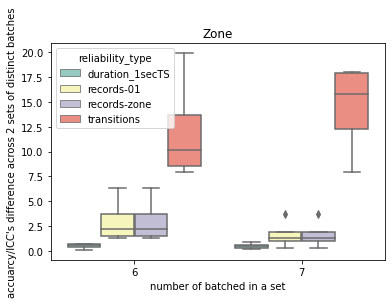

C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


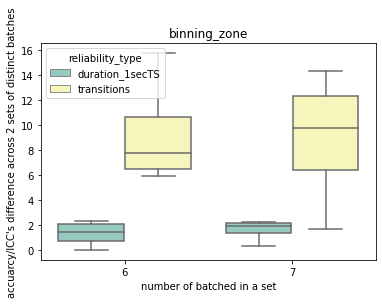

C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


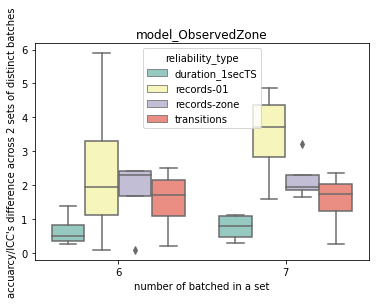

(80, 6)
LOOk AT THIS AND VERIFY THE OUTPUT


,runID,reliability_type,nbr_batch,accuracy_ICC,li_batch_selected,accuracy_ICC_diff


,ICC,F,df1,df2,pval,CI95%
88,1.0,-3.498332e+15,6.0,6.0,1.0,"[1.0, 1.0]"
179,1.0,-6.738842e+15,16.0,16.0,1.0,"[1.0, 1.0]"
180,1.0,-6.738842e+15,16.0,16.0,1.0,"[1.0, 1.0]"
183,1.0,-7.351464e+15,16.0,16.0,1.0,"[1.0, 1.0]"
184,1.0,-7.351464e+15,16.0,16.0,1.0,"[1.0, 1.0]"


In [42]:
#visualize the results
li_df = []
for m, df_ in df_results[df_results['nbr_batch']!=len(df_testing['BatchID'].unique())].groupby(['method']):    
    #compute difference across the associated batches combination
    df_ = df_.filter(['reliability_type','accuracy_ICC','nbr_batch','runID','li_batch_selected'], axis=1)
    df_ = df_.groupby(['runID','reliability_type','nbr_batch'])['accuracy_ICC','li_batch_selected'].agg(lambda x: list(x)).reset_index()
    df_['accuracy_ICC_diff'] = df_['accuracy_ICC'].map(lambda x: abs(x[0]-x[1])*100)
    li_df.append(df_)
    #display(df_.head(3))
    #plot
    ax = sns.boxplot(x="nbr_batch", y="accuracy_ICC_diff", hue="reliability_type", data=df_, palette="Set3")
    plt.title(m)
    plt.xlabel('number of batched in a set')
    plt.ylabel('accuarcy/ICC\'s difference across 2 sets of distinct batches')
    #plt.savefig(os.path.join(path_extracted_data_cleaning,'ReliabilityStability_'+m+'.png'), bbox_inches='tight')
    plt.show()
df_acc_diff = pd.concat(li_df)
print(df_acc_diff.shape)
df_acc_diff.to_csv(os.path.join(path_extracted_data_cleaning,'reliability_RESULTs_acc_difference.csv'), sep=';', index=False)
print('LOOk AT THIS AND VERIFY THE OUTPUT')
display(df_acc_diff[df_acc_diff['accuracy_ICC_diff']>30].head(10))
#ATTENTION: VERIFY p_val!!!!!!!
#for df_results['reliability_type']=='transitions')], verify all p-values are smaller <05 (dont remove the other one as I am 
#not sure its not cheating)
df_results[df_results['pval']>0.05][['ICC','F','df1','df2','pval','CI95%']]

(21, 52)


Text(0, 0.5, 'accuraccy - ICC scores')

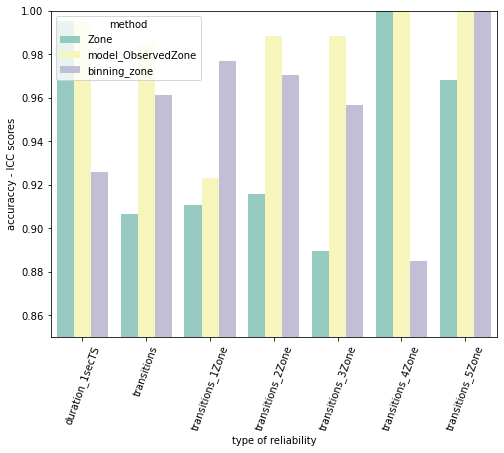

In [43]:
li_rel_type = ['duration_1secTS', 'transitions','transitions_1Zone', 'transitions_2Zone', 'transitions_3Zone',
               'transitions_4Zone', 'transitions_5Zone']
df_plt = df_results[(df_results['nbr_batch']==len(df_testing['BatchID'].unique()))&\
                    (df_results['reliability_type'].isin(li_rel_type))]
print(df_plt.shape)
#df_plt[['runID','method','accuracy_ICC']]
plt.figure(figsize=(8,6))
ax = sns.barplot(x="reliability_type", y="accuracy_ICC", hue="method", data=df_plt, palette="Set3")
plt.xticks(fontsize=10,rotation=70)
plt.ylim(0.85,1)
plt.xlabel('type of reliability')
plt.ylabel('accuraccy - ICC scores')
#plt.savefig(os.path.join(path_extracted_data_cleaning,'ReliabilityMethodsComparison.png'), bbox_inches='tight')

df_results[(df_results['runID']=='65999852-3024-11eb-a16f-9822ef705bb4')&\
           (df_results['reliability_type']=='transitions')] #[['accuracy','ICC','accuracy_ICC']]

df_results = pd.read_csv(os.path.join(path_extracted_data_cleaning,'reliability_RESULTS.csv'), sep=';')
print(df_results.shape)
df_results.head(3)